**The Gaussian Copula**

The Gaussian Copula is a tool which is widely used in both Quantitative Finance and Actuarial applications. It is useful for modelling the dependencies of different risk structures and is particulary useful for capturing tail behaviour. 

The copula allows us to combine seperate univariate distributions into multivariate distributions, like an emulsifier that provides a framework for water and oil to mix, forcing them to interact and examining the resulting multi-variate distribution. The Gaussian copula in particular assumes these distributions follow a multivariate normal distribution. 

*Formation of the Gaussian copula*:

Assume we have 2 standard normal marginal distributions:
$$
Z_1 \sim \mathbb{N}(0,1)\\
Z_2 \sim \mathbb{N}(0,1)
$$

We then transform these variables into normal random variables using the probability integral theorem.\\
$$
u_1=F_1(Z_1)\\
u_2=F_2(Z_2)
$$

Now we can create the Gaussian Copula where
$$
C(u_1,u_2)=\phi_2(\phi^-1(U_1),\phi^-1(U_2)|\rho)
$$
Where:
$\phi^-1$ is the inverse normal CDF and $\phi_2$ is the CDF of the inverse normal multivariate distribution and $\rho$ is the correlation coefficient.

This can be extended to $n$ assets using an $n*n$ covariance matrix


The copula allows us to looks at how different asset/liability classes move in relation to each other. This is essential for analysing markets or pricing insurance contracts as the assumption of independance between risks does not always hold and it is essential to model this behaviour. Spotting these 'pairs' can aid in areas such as:\\
- Identifying arbitrage opporunities by finding moving pairs 
- Developing more comprehensive risk management strategies by looking at joint movement of different asset classes helping to avoid significant losses

In this document I will explore a quantiative and actuarial use respectively.

**Quantiative Finance Implementation**

In [1]:
#import libraries
import numpy as np
import pandas as pd
import yfinance as yf #enables downloading of stock data 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, multivariate_normal

In [2]:
#Downloading data
tickers=['AAPL','MSFT','AMZN','GOOGL','META','TSLA','NVDA','PYPL']
#Choose more recent data as asset classes are not stationary and market moveement patterns change over time
# Take the adjusted close prices
df= yf.download(tickers, start = '2015-01-01', end = '2024-01-01')['Close']
ret = df.pct_change().dropna()
ret.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  8 of 8 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,PYPL,TSLA
Date,,,,,,,,
2015-07-07,-0.002460,0.001560,0.008082,-0.003769,-0.002027,-0.018840,-0.002452,-0.042328
2015-07-08,-0.024823,-0.016074,-0.015145,-0.018001,-0.001354,-0.007074,-0.052430,-0.048231
2015-07-09,-0.020397,0.010915,0.005446,0.002685,0.006329,-0.012214,-0.005764,0.011610
2015-07-10,0.026735,0.020995,0.021041,0.024103,0.002022,0.017517,0.005507,0.004769
2015-07-13,0.019306,0.027192,0.028088,0.024446,0.020848,0.006582,0.060248,0.011615


Now lets identify the correlation matrix. Here we can identify pairs with low correlations allowing us to form diversified portoflios as well as assets with high correlation in order to see how asset classes have dependence which can create arbitrage opporunities. 

In [3]:
#Covariance matrix
cov_mat=ret.cov()
print(cov_mat)

Ticker      AAPL      AMZN     GOOGL      META      MSFT      NVDA      PYPL  \
Ticker                                                                         
AAPL    0.000342  0.000227  0.000214  0.000247  0.000230  0.000329  0.000247   
AMZN    0.000227  0.000437  0.000250  0.000308  0.000246  0.000346  0.000274   
GOOGL   0.000214  0.000250  0.000332  0.000291  0.000236  0.000316  0.000240   
META    0.000247  0.000308  0.000291  0.000583  0.000253  0.000368  0.000329   
MSFT    0.000230  0.000246  0.000236  0.000253  0.000307  0.000340  0.000253   
NVDA    0.000329  0.000346  0.000316  0.000368  0.000340  0.000954  0.000380   
PYPL    0.000247  0.000274  0.000240  0.000329  0.000253  0.000380  0.000588   
TSLA    0.000293  0.000309  0.000253  0.000300  0.000268  0.000482  0.000356   

Ticker      TSLA  
Ticker            
AAPL    0.000293  
AMZN    0.000309  
GOOGL   0.000253  
META    0.000300  
MSFT    0.000268  
NVDA    0.000482  
PYPL    0.000356  
TSLA    0.001314  


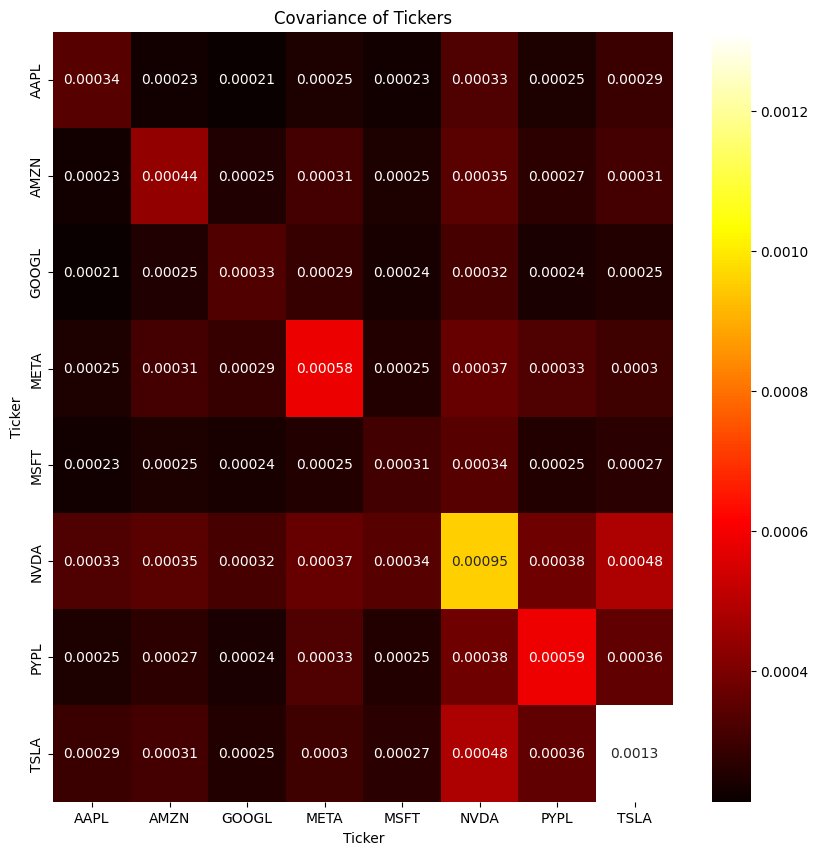

In [4]:
#plot the matrix using a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cov_mat, annot = True, cmap= 'hot')
plt.title('Covariance of Tickers')
plt.show()

In [5]:
#We can find asset pairs good for a diversified portfolio by finding pairs with low covariance such as 
diversifiable_risk = cov_mat.where(cov_mat <0.0003).dropna(how='all')
diversifiable_risk

lowest_cov_pair=np.unravel_index(np.argmin(cov_mat), cov_mat.shape)
low_pair= [tickers[i] for i in lowest_cov_pair]
print(f"The tickers of pairs with most diversifiable risk are {low_pair}")

The tickers of pairs with most diversifiable risk are ['AAPL', 'AMZN']


However it is important to remember that factors like asset expected return are also important for building a diversified portfolio not simply identifying pairs with low covariance. We can also analyse the probability of joint events which exceed a specified risk tolerence using the gaussian copula. The figure I use for identifying extreme events can be changed to reflect a subjective risk tolerence level e.g. a pension fund which is highly regulated may have a lower risk tolerence then a hedge fund. 

In [6]:
#Lets simulate values from a multivariate normal distribution for our gaussian copula
multinormal = multivariate_normal(mean=np.zeros(len(tickers)), cov = cov_mat)
#Generate our uniform random variables U(0,1) using the Probability Integral Transform
copula_samples = norm.cdf(multinormal.rvs(1000000))

#Now lets identify 'extreme events', in this case extreme negative returns where for all the assets
extreme_events = copula_samples < norm.cdf(-1.5) #We define extreme events as returns below -1.5 standard deviations select large negative tails
#This creates a boolean array of true and false values if the condition is met. 

#Calculate the joint probability of extreme events by taking the means across of exteme events (losses) occuring across all assets allowing us to manage risk against joint losses.
joint_prob = np.mean(np.all(extreme_events, axis = 1))
print(f"Joint probability of extreme losses: {joint_prob}")

Joint probability of extreme losses: 0.0


Now lets look for assets with strong dependencies to identify pair trading opportunities. 

In [7]:
#simulate a normal distribution 
ranked = norm.ppf(ret.rank(pct=True)) #ranked returns
corr_matrix= np.corrcoef(ranked, rowvar=False) #correlation matrix 

#Replace diagnol values so they dont affect finding the maximum correlation value
np.fill_diagonal(corr_matrix, -np.inf)
#Hide infinite values
corr_matrix = np.ma.masked_invalid(corr_matrix)

#Find the maximum correlation values using this approach in order to find the pairs of tickers with the maximum correlation value
# Find the most correlated pair of assets
max_corr_idx = np.unravel_index(np.argmax(corr_matrix), corr_matrix.shape)
pair_tickers = [tickers[i] for i in max_corr_idx]
if pair_tickers[0]==pair_tickers[1]: 
    print('No meaningful pairs')
else: 
    print(f"Pairs of tickers with the maximum correlation: {pair_tickers}")

No meaningful pairs


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


We found no arbitrage opporunities in this ticker set. THis is a brief introduction of how gaussian copulas can be applied in quantitative finance to discover financial dependencies between variables.

**Actuarial Implementation**

In insurance and reinsurance, the ability to estimate losses is crucial. This is especially true of joint-occuring losses which can overwhelm the reserves held by the insurer. In a real-world scenario, such as container ship insurance, the underlying assumption of indepedent libailities cannot hold. This is due to the underlying risk structure being dependent as adverse conditions such as severe weather or geopolitical issues can cause systematic changes in the risk profile across the portfolio making it essential for insurers to accurate predict these joint extreme losses which concentrate in the tails of the joint distribution. This joint distribution can be modelled using copulas and analysing the tail risk can be essential in helping insurers avoid ruin. This leads to more effective risk management and capital allocation. 

In [8]:
#import relevant libraries
from copulas.multivariate import GaussianMultivariate
from scipy.stats import norm, lognorm, genpareto

#set seed as we will simulate data. In real life we would take existing claims data to fit the copula
np.random.seed(123)

We analyze the joint risk profile of two insurance classes: Property claims and Container Ship claims. Each has a distinct claims distribution designed to approximate real worl claim scenarios. This can be improved by fitting a distribution to real world data.

Property Claims:
 - Modeled using a lognormal distribution with s = 0.7 to reflect moderate right skew as there is a moderate possibility for large claim sizes. 
 - This captures the fact that most property claims are relatively small, but some large claims exist (e.g., structural damage, flooding).
 - We set scale = np.exp(8) ensuring claim sizes are not too large but can represent the large claim sizes possible
 - By using lognormal we can show property claims are not symmetrical—losses tend to be small to moderate but more frequent, but extreme losses are rarely catastrophic.

Container Ship Claims:
 - Modeled using a Generalized Pareto Distribution (GPD) with c = 0.3 > 0.
 - This heavier-tailed distribution accounts for non-trivial extreme events (e.g., total cargo loss, shipwrecks), while ensuring they don’t occur too frequently.
 - The scale parameter is set to np.exp(12) representing the larger potential loss values in shipping insurance.
 - The GPD distribution for shipping claims represents the capacity high-severity but low-frequency, most claims are moderate, but a few can be catastrophic.

By modeling these distributions appropriately, we can capture realistic risk profiles, allowing actuaries and insurers to make informed decisions about capital reserves, pricing strategies, and risk mitigation.

In [9]:
#generate some claims data
property_claims= lognorm(s=0.7, scale = np.exp(4)).rvs(10000)
ship_claims=genpareto(c=0.5, loc=10000, scale=np.exp(6)).rvs(10000)

# Transform the data to uniform using probability integral transform (matching parameters)
uniform_sample_property = lognorm.cdf(property_claims, s=0.7, scale=np.exp(4))
uniform_sample_ship = genpareto.cdf(ship_claims, c=0.5, loc=10000, scale=np.exp(6))

# Compute correlation coefficient
rho = np.corrcoef(uniform_sample_property, uniform_sample_ship)[0, 1]
rho

#Fit a Gaussian copula to the data
copula = GaussianMultivariate()
copula.fit(np.column_stack([uniform_sample_property, uniform_sample_ship]))

Lets look at how the potential of joint losses through copula modelling will affect an excess of loss reinsurer and perform a ruin simulation.

Bankruptcy occurred at iterations: [16, 362, 199, 2942, 21, 1006, 2121, 418, 652, 2874, 1983, 1360, 323, 109, 120, 741, 14, 152, 243, 292, 345, 202, 422, 188, 569, 489, 3412, 1108, 3529, 103, 1869, 1852, 2141, 416, 986, 1797, 171, 937, 1245, 168, 628, 237, 420, 406, 65, 2080, 396, 1142, 94, 157, 1354, 43, 114, 580, 212, 340, 2233, 796, 389, 1003, 1011, 5, 30, 125, 221, 634, 1606]
The probability of ruin is: 0.67


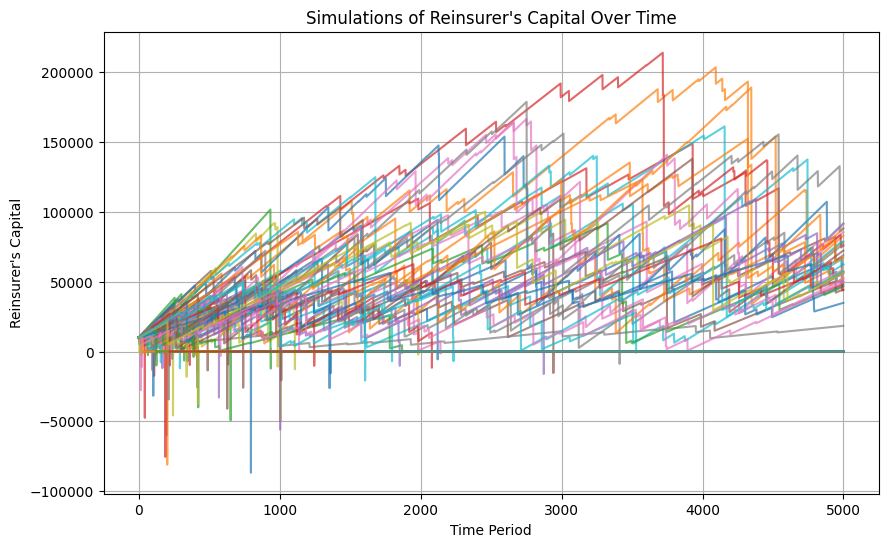

In [ ]:

def run(n):
    bankruptcy_results = []
    simulation_data = []
    
    for _ in range(n):
        # Simulate the joint insurance losses
        uniform_copula_sample = np.random.uniform(size=(5000, 2))  # Assuming copula sampling
        simulated_losses_property = lognorm(s=0.7, scale=np.exp(4)).ppf(uniform_copula_sample[:, 0])
        simulated_losses_ship = genpareto(c=0.5, loc=10000, scale=np.exp(6)).ppf(uniform_copula_sample[:, 1])
        total_losses = simulated_losses_property + simulated_losses_ship

        #Simulate reinsurer
        initial_surplus = 10000  # Initial amount insurer starts with
        retention = 20000  # Amount above which the reinsurer insures claims
        cover_limit = 100000  # Maximum cover provided by reinsurer

        # Calculate reinsurer payouts and premiums
        load_factor = 1.2
        reinsurer_payouts = np.clip(total_losses - retention, 0, cover_limit)
        expected_payout = np.mean(reinsurer_payouts)
        premium = expected_payout * load_factor

        # Reinsurer Simulation Function
        def reinsurer_simulation():
            bankruptcy_times = []
            reinsurer_health = np.zeros(5000)
            reinsurer_health[0] = initial_surplus

            for i in range(1, 5000):
                reinsurer_health[i] = reinsurer_health[i - 1] + premium - reinsurer_payouts[i]

                if reinsurer_health[i] < 0:
                    bankruptcy_times.append(i)
                    break  # Stop at the first bankruptcy event

            return bankruptcy_times, reinsurer_health

        # Run the simulation
        bankruptcies, simulations = reinsurer_simulation()
        bankruptcy_results.extend(bankruptcies)
        simulation_data.append(simulations)
        

    print("Bankruptcy occurred at iterations:", bankruptcy_results)
    
    return bankruptcy_results, np.array(simulation_data)

#Lets run the simulation
m=100
bankruptcy_sim, all_run = run(m)

prob_of_ruin = len(bankruptcy_sim)/m
print(f"The probability of ruin is: {prob_of_ruin}")

plt.figure(figsize=(10, 6))
plt.plot(all_run.T, alpha=0.7)  # Transpose so that each line represents a simulation
plt.xlabel("Time Period")
plt.ylabel("Reinsurer's Capital")
plt.title("Simulations of Reinsurer's Capital Over Time")
plt.grid(True)
plt.show()

Now lets vary the premium load factor to to reduce the probability of ruin to an acceptable level of risk. The load factor threshold can be changed to reflect a personal risk tolerence. 

In [60]:

def run(n, load_factor):
    bankruptcy_count = 0
    
    for _ in range(n):
        # Simulate the joint insurance losses
        uniform_copula_sample = np.random.uniform(size=(5000, 2))  # Assuming copula sampling
        simulated_losses_property = lognorm(s=0.7, scale=np.exp(4)).ppf(uniform_copula_sample[:, 0])
        simulated_losses_ship = genpareto(c=0.5, loc=10000, scale=np.exp(6)).ppf(uniform_copula_sample[:, 1])
        total_losses = simulated_losses_property + simulated_losses_ship

        #Simulate reinsurer
        initial_surplus = 10000  # Initial amount insurer starts with
        retention = 20000  # Amount above which the reinsurer insures claims
        cover_limit = 100000  # Maximum cover provided by reinsurer

        # Calculate reinsurer payouts and premiums
        reinsurer_payouts = np.clip(total_losses - retention, 0, cover_limit)
        expected_payout = np.mean(reinsurer_payouts)
        premium = expected_payout * load_factor

        # Reinsurer Simulation Function
        def reinsurer_simulation():
            reinsurer_health = np.zeros(5000)
            reinsurer_health[0] = initial_surplus

            for i in range(1, 5000):
                reinsurer_health[i] = reinsurer_health[i - 1] + premium - reinsurer_payouts[i]

                if reinsurer_health[i] < 0:
                    return True
                    break  # Stop at the first bankruptcy event

            return False
        if reinsurer_simulation():
            bankruptcy_count += 1
    
    prob_of_bankruptcy = bankruptcy_count / n
    return prob_of_bankruptcy

        
#Lets run the simulation
m=100

def find_safe_loading_factor(start=1, step = 0.5, max_load_factor=30, threshold = 1e-6):
    load_factor = start
    while load_factor < max_load_factor:
        prob_of_ruin = run(m, load_factor)
        
        if prob_of_ruin < threshold:
            print(f"Safe loading factor found:{load_factor}")
            return load_factor
        
        load_factor +=step
        
    print("No safe loading factor found")
    return None  

safe_loading_factor= find_safe_loading_factor()

Safe loading factor found:15.5


As can be seen in order to get the probability of ruin to 0 we require a very high loading factor, much higher than most clients would be willing to pay. This is why a certain level of defined risk taking is required in the insurance industry. 